# product name analysis

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_pickle('df.pkl')

## EDA & data cleaning
We now analyze produce at a finer granularity. Hopefully we could get some sense of what the popular items are.

In [42]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.stem.wordnet import WordNetLemmatizer

import string
from wordcloud import WordCloud

from collections import Counter

In [43]:
def product_word_list(product_name:str, stop:list):
    product_name = word_tokenize(product_name)   # "Bag of Organic Bananas"
    product_name = [x.lower() for x in product_name]
    name = [word for word in product_name if word not in stop]  # [Bag, Organic, Bananas]
    return name

# test the function
# product_word_list(2,'Bag of Organic Bananas',stop)

In [44]:
def plural_to_single(words:list):
    output = []
    Lem = WordNetLemmatizer()
    for word in words :
        lemword = Lem.lemmatize(word)
        output.append(lemword)
    return output

In [45]:
def remove_punc(text:str):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

sample = 'Bag of Organic Bananas (3) & Oranges !'
print(remove_punc(sample))
print(word_tokenize(remove_punc(sample)))

Bag of Organic Bananas 3  Oranges 
['Bag', 'of', 'Organic', 'Bananas', '3', 'Oranges']


In [46]:
produce_info = df.loc[df.department == 'produce',['order_number','product_name']].reset_index(drop=True)
produce_info.head()

,order_number,product_name
0,1,Organic Baby Spinach
1,1,Michigan Organic Kale
2,1,Bag of Lemons
3,1,Organic Thyme
4,1,Sage


In [9]:
# sample for analysis
np.random.seed(42)
n_sample = 10000
tmp = produce_info.loc[np.random.choice(np.arange(len(produce_info)),n_sample, replace=True),:]
tmp

,order_number,product_name
6423388,10,"Organic Mini Sweet Pepper, Pint"
6550634,52,Packaged Grape Tomatoes
4304572,1,Bag of Organic Bananas
2234489,7,Organic Fuji Apples
9524682,54,Organic D'Anjou Pears
...,...,...
3017721,1,Jalapeno Peppers
5638132,13,Organic Raspberries
5653020,11,Red Vine Tomato
7400236,62,Apple Honeycrisp Organic


In [10]:
# this cell takes long time to run
tmp['product_name'] = tmp['product_name'].apply(remove_punc)
tmp['product_total'] = tmp.apply(lambda x: product_word_list(x['product_name'], stop), axis=1)
tmp['product_total'] = tmp['product_total'].apply(plural_to_single)
tmp = tmp.reset_index(drop=True)
tmp

,order_number,product_name,product_total
0,10,Organic Mini Sweet Pepper Pint,"[organic, mini, sweet, pepper, pint]"
1,52,Packaged Grape Tomatoes,"[packaged, grape, tomato]"
2,1,Bag of Organic Bananas,"[bag, organic, banana]"
3,7,Organic Fuji Apples,"[organic, fuji, apple]"
4,54,Organic DAnjou Pears,"[organic, danjou, pear]"
...,...,...,...
9995,1,Jalapeno Peppers,"[jalapeno, pepper]"
9996,13,Organic Raspberries,"[organic, raspberry]"
9997,11,Red Vine Tomato,"[red, vine, tomato]"
9998,62,Apple Honeycrisp Organic,"[apple, honeycrisp, organic]"


In [48]:
def count_word_freq(df:pd.DataFrame):
    produce = Counter()

    for i in range(len(tmp)):
        num = df['order_number'][i]
        for j in range(num):
            produce.update(df['product_total'][i])
    return produce

produce = count_word_freq(tmp)
produce.most_common(20)

[('organic', 50),
 ('mushroom', 11),
 ('leek', 10),
 ('onion', 8),
 ('baby', 7),
 ('spinach', 7),
 ('broccoli', 7),
 ('green', 7),
 ('whole', 7),
 ('white', 7),
 ('shallot', 7),
 ('carrot', 6),
 ('russet', 5),
 ('potato', 5),
 ('garlic', 5),
 ('chive', 4),
 ('rabe', 4),
 ('fresh', 4),
 ('cauliflower', 4),
 ('vidalia', 4)]

In [12]:
# check if we need further cleaning of the corpus
sorted(produce.keys(), key = lambda x:len(x))[:10]

['3', '2', 'ha', 'xl', 'lb', 'fe', 'pk', 'og', 'mg', 'bag']

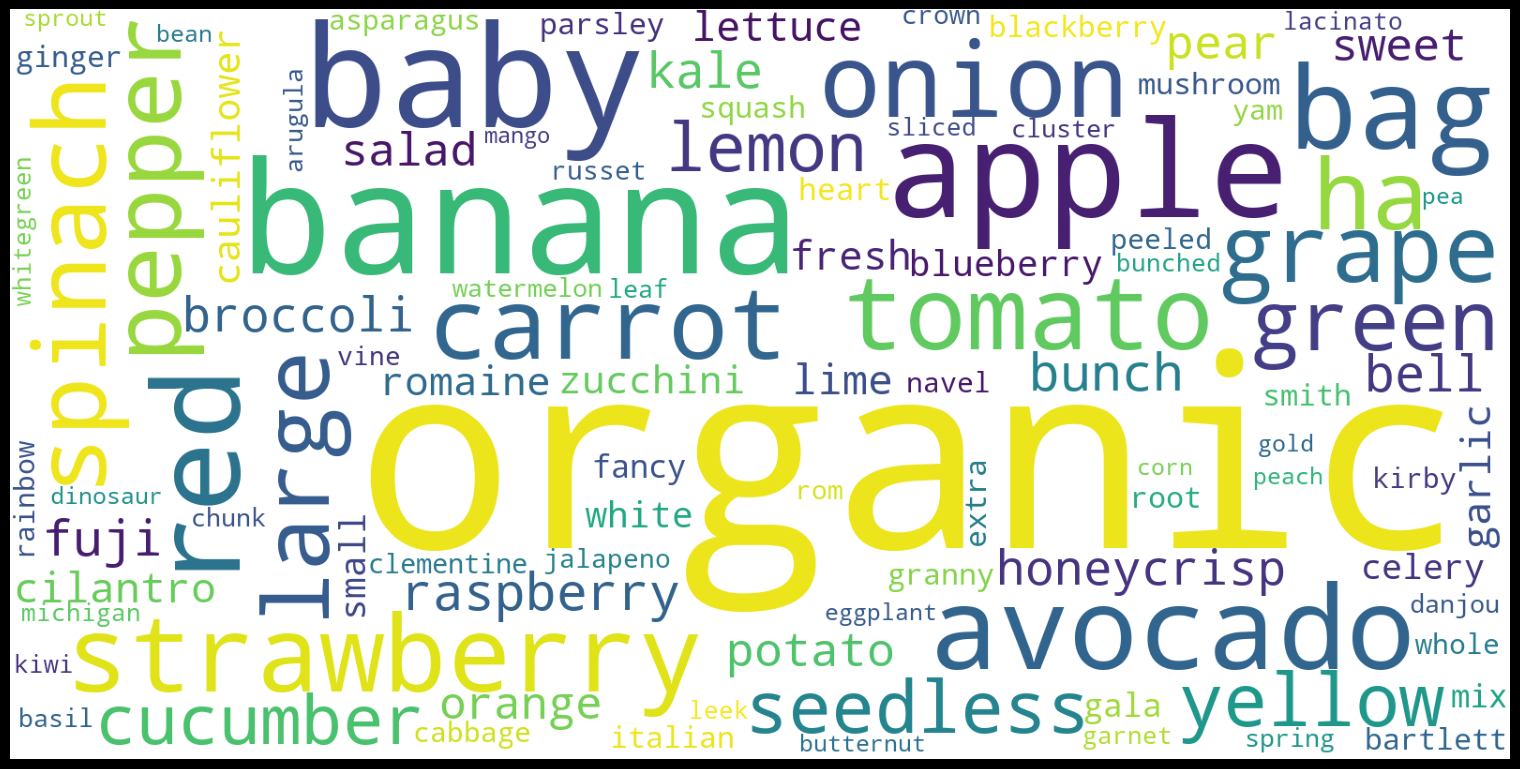

In [13]:
# from wordcloud import WordCloud

n_words = 100
dic = {}
for items in produce.most_common(n_words):
    dic[items[0]] = items[1]

word_cloud = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(dic)

plt.figure( figsize=(15,8), facecolor='k')
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## user profile for produce_enthusiast class

From department level analysis, we grouped the users to several classes. For users that purchase many items from produce department, we perform finer anlaysis on their preferences.

In [30]:
df = pd.read_pickle('df.pkl')
df.user_id.nunique()     # 206209 customers 

206209

In [27]:
user_segment = pd.read_csv("user_segment.csv")

In [28]:
produce_enthusiast = user_segment.loc[user_segment['class'] == "produce_enthusiast","user_id"].tolist()
len(produce_enthusiast)

32582

In [32]:
df = df.loc[df.user_id.isin(produce_enthusiast)]
df = df.loc[df.department == 'produce',:]
df.user_id.nunique()   # number should be equal to length of the list

32582

In [58]:
# split df to process by chunks
# if you have good computation resources, just ignore the step

user_list = df.user_id.unique()
n = len(user_list)

chunk_size = 10000
num_chunk = n//chunk_size + 1

for i in range(num_chunk):
    users = user_list[chunk_size*i: chunk_size*(i+1)]
    d = df.loc[df.user_id.isin(users)]
    d = d[['user_id','order_number','product_name']]
    d.to_csv('df_produce_chunk/df_{}.csv'.format(i+1))

In [217]:
for chunk in range(1,num_chunk+1):
    print('processing chunk {} data'.format(chunk))
    df_chunk = pd.read_csv('df_produce_chunk/df_{}.csv'.format(chunk))
    chunk_users = df_chunk.user_id.unique()
    df_product = pd.DataFrame()


    for i in range(len(chunk_users)):
        u = chunk_users[i]
        tmp = df_chunk.loc[df_chunk.user_id == u, ['user_id','order_number','product_name']].reset_index(drop=True)
        tmp['product_name'] = tmp['product_name'].apply(remove_punc)
        tmp['product_total'] = tmp.apply(lambda x: product_word_list(x['product_name'], stop), axis=1)
        tmp['product_total'] = tmp['product_total'].apply(plural_to_single)
        tmp = tmp.reset_index(drop=True)
        user_dic = count_word_freq(tmp)

        for k,v in user_dic.items():
            df_product.loc[u,k] = v

#         if i%2000 == 0:
#             print("{} users processed".format(i))

    df_product.to_pickle('df_produce_chunk/users_chunk{}.pkl'.format(chunk))

In [67]:
del df, df_product

In [81]:
chunk1 = pd.read_pickle('df_produce_chunk/users_chunk1.pkl')
chunk2 = pd.read_pickle('df_produce_chunk/users_chunk2.pkl')
chunk3 = pd.read_pickle('df_produce_chunk/users_chunk3.pkl')
chunk4 = pd.read_pickle('df_produce_chunk/users_chunk4.pkl')

In [92]:
data = pd.merge(chunk1.transpose(), chunk2.transpose(), how='outer',left_index=True, right_index=True)
data = pd.merge(data, chunk3.transpose(), how='outer',left_index=True, right_index=True)
data = pd.merge(data, chunk4.transpose(), how='outer',left_index=True, right_index=True)
data = data.transpose()
data.shape

(32582, 807)

In [93]:
data

,1,100,12,1200,2,3,4,5,50,5050,...,xl,yam,yellow,yogurt,young,yucca,yukon,zen,zesty,zucchini
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,32.0,189.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0
206187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are tremendous amount of keyword columns in the dataframe. 
* To save computational complexity and reduce noise, we use eliminate columns that have high percentage of NA values. 
* Besides, the numbers seem to provide little value here, so we also delete them

When price/incremental sales data are available, we could use 80-20 rule to partition the users into "high-value" and "low-value". Focus on the high-value customers if given limited time and space.

In [101]:
np.sort(data.columns)

array(['1', '100', '12', '1200', '2', '3', '4', '5', '50', '5050', '5lb',
       '5lettuce', '90100', 'abate', 'acorn', 'activity', 'added', 'alba',
       'alfalfa', 'alice', 'aloe', 'ambrosia', 'american', 'americana',
       'anaheim', 'angel', 'antioxidant', 'appeal', 'apple', 'apricot',
       'arbol', 'aril', 'armenian', 'artichoke', 'artihearts', 'artisan',
       'arugula', 'asian', 'asparagus', 'asparationbroccolinibaby',
       'ataulfo', 'aurora', 'avocado', 'baby', 'bacon', 'bag', 'bagged',
       'balsamic', 'banana', 'barbara', 'barbecue', 'bartlett', 'basil',
       'bay', 'bbq', 'bean', 'bear', 'beauregard', 'beefsteak', 'beet',
       'belgian', 'bell', 'bella', 'bellas', 'belle', 'berry', 'bibb',
       'bicolor', 'bing', 'biologique', 'bistro', 'bite', 'bitesize',
       'black', 'blackberry', 'blackeyed', 'blazin', 'blend', 'bleu',
       'blood', 'blueberry', 'blushing', 'boiler', 'bok', 'bolthouse',
       'boneless', 'boniato', 'boomer', 'bosc', 'boston', 'bowl',

In [102]:
data['lettuce'] = data['lettuce']+data['5lettuce']

In [103]:
data = data.drop(['1', '100', '12', '1200', '2', '3', '4', '5', '50', '5050', '5lb','5lettuce', '90100'],axis=1)
data

,abate,acorn,activity,added,alba,alfalfa,alice,aloe,ambrosia,american,...,xl,yam,yellow,yogurt,young,yucca,yukon,zen,zesty,zucchini
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,32.0,189.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0
206187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
val = (data.isna()).sum().sort_values()
val

organic      949
baby        8234
banana      9941
red        10393
avocado    10962
           ...  
double     32581
cup        32581
stemmed    32581
ravioli    32581
squeeze    32581
Length: 794, dtype: int64

In [114]:
val.describe()

count      794.000000
mean     31002.661209
std       3848.484717
min        949.000000
25%      31659.250000
50%      32509.500000
75%      32572.000000
max      32581.000000
dtype: float64

In [123]:
# feel free to tune the threshold by your preference
data = data.drop(val[val>32572].index.tolist(), axis=1)
data.shape

(32582, 605)

In [125]:
data = data.fillna(0)

### Extract information from **product_name**

Consider customers' own order history as "document", and entire order history as "corpus". calculate **TF-IDF** scores for each word in the "document", and obtain a vector representation for each customer.

* TF: number of apperances of the word in the user's purchase history / total number of words in the purchase history

* IDF: *log*(total number of users/number of users that have purchase products containing the word)

In [153]:
# compute term frequency
TF = data.copy()
TF = TF.div(TF.sum(axis=1), axis=0) 
TF

,acorn,alfalfa,alice,aloe,ambrosia,american,americana,anaheim,angel,appeal,...,wonder,xl,yam,yellow,yogurt,young,yucca,yukon,zen,zucchini
8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.004566,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.004886
16,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
22,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.091667,0.0,0.0,0.0,0.0,0.0,0.000000
48,0.0,0.0,0.007828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.045010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206180,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.011927,0.070444,0.0,0.0,0.0,0.0,0.0,0.000000
206183,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.043032
206187,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.011897,0.0,0.0,0.0,0.0,0.0,0.000000
206190,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [152]:
# compute inverse document frequency
IDF = np.log(len(data)/data.apply(lambda x: sum(x>0))) 
IDF.sort_values()

organic        0.029559
baby           0.291310
banana         0.363998
red            0.384163
avocado        0.410141
                 ...   
bunashimeji    8.088930
juicy          8.088930
original       8.088930
santa          8.088930
combo          8.088930
Length: 605, dtype: float64

In [157]:
user_embed = TF.mul(IDF)

In [158]:
user_embed

,acorn,alfalfa,alice,aloe,ambrosia,american,americana,anaheim,angel,appeal,...,wonder,xl,yam,yellow,yogurt,young,yucca,yukon,zen,zucchini
8,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.006806,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
10,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.005999
16,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
22,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.062026,0.0,0.0,0.0,0.0,0.0,0.000000
48,0.0,0.0,0.03923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.055260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206180,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.017776,0.047666,0.0,0.0,0.0,0.0,0.0,0.000000
206183,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.052832
206187,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.008050,0.0,0.0,0.0,0.0,0.0,0.000000
206190,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [209]:
# randomly pick some users to see their representations
user_embed.iloc[1,:].sort_values(ascending=False)

herb       0.080202
poultry    0.077387
flat       0.075498
rosette    0.059989
mache      0.057312
             ...   
envy       0.000000
enoki      0.000000
english    0.000000
endless    0.000000
kabocha    0.000000
Name: 10, Length: 605, dtype: float64

In [214]:
user_embed.iloc[8,:].sort_values(ascending=False)

wonder     0.084668
wild       0.068807
french     0.061883
bean       0.057880
gourmet    0.053867
             ...   
family     0.000000
fancy      0.000000
farm       0.000000
fat        0.000000
kabocha    0.000000
Name: 84, Length: 605, dtype: float64

In [216]:
user_embed.iloc[123,:].sort_values(ascending=False)

blueberry    0.085138
kiwi         0.056060
bag          0.034342
grape        0.030301
passion      0.027823
               ...   
fajita       0.000000
family       0.000000
fancy        0.000000
farm         0.000000
zucchini     0.000000
Name: 853, Length: 605, dtype: float64

## conclusion and more
Congratulations! You've reached the end of this notebook. However, there are so much more to explore with the rich text information. For example, you could use them as features for user segmentation for produce enthusiast, or you could get some sense of what the user likes based on their historical data. Several ideas are listed as follows:

### clustering using embeddings
Notice that the data is sparse, so directly apply k-means (or any distance-based clustering) is unlikely to give meaningful results. A reasonable approach is apply dimension reduction technique. 

#### NMF
A suitable model for this task would be [Non-negative matrix factorization (NMF or NNMF)](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization). The NMF method is good for matrix with no negative elements, and has nice inherent clustering property (i.e., it automatically clusters the columns of input data). 

That being said, one way of interpreting  the results of NMF as clustering could be: when we are doing *n-dimensional* NMF, we can think of the columns of the resulting matrix as clusters, with the value in the cell $i$ being the degree of association of the observation to the cluster $i$.

scikit-learn API: [sklearn.decomposition.NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

#### traditional method
If you want to explore the traditional method, you could also apply PCA or SVD before clustering. Remember to scale the data before applying PCA.

#### update model by time
As a customer place more and more orders, it would be hard to retrain the model all the past data. Besides, using orders from three years ago to help making recommenadtion decision is not reasonable as well. To solve this problem, we could decrease the amount of say for data that are long time ago. (e.g., exponential smoothing) 

### salvage products from "missing" department

Some products are marked "missing" for their department attribute. To recover their labels, we could train a multi-class classification model using product_name as input. The model is trained using data with valid department label, and could be used to predict these "homeless" products. 

Furthermore, it could be used to get department label whenever a new product is on shelf.

**Thanks for reading and have fun playing with the data!**